In [3]:
%matplotlib inline
import time
import os
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

PYTORCH_MODEL = "runs/detect/visdrone_final/weights/best.pt"
TENSORRT_MODEL = "runs/detect/visdrone_final/weights/best.engine"
DATA_CONFIG = "data/visdrone_yolo/visdrone_config.yaml"

In [4]:
def test_model(model_path, format_name):
    print(f"\n{'='*60}")
    print(f"Benchmarking {format_name}")
    print('='*60)

    # Load model
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Error loading {model_path}: {e}")
        return None
    
    # Get model file size
    file_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    
    # Run validation
    start_time = time.time()
    metrics = model.val(
        data=DATA_CONFIG,
        split="test",
        device=0,
        imgsz=640,
        batch=1,
        verbose=False
    )
    total_time = time.time() - start_time

    # Extract metrics
    map50 = metrics.box.map50
    map50_95 = metrics.box.map
    
    # Per-class metrics
    per_class_ap50 = metrics.box.ap50
    per_class_ap = metrics.box.ap
    
    # Speed metrics
    preprocess_time = metrics.speed["preprocess"]
    inference_time = metrics.speed["inference"]
    postprocess_time = metrics.speed["postprocess"]
    total_per_image = preprocess_time + inference_time + postprocess_time
    
    fps = 1000 / inference_time
    
    # Precision and Recall
    precision = metrics.box.p
    recall = metrics.box.r
    
    print(f"\n📊 {format_name} Results:")
    print(f"  Model Size: {file_size_mb:.2f} MB")
    print(f"  mAP@50: {map50:.4f}")
    print(f"  mAP@50-95: {map50_95:.4f}")
    print(f"  Inference Latency: {inference_time:.2f} ms")
    print(f"  FPS: {fps:.1f}")
    print(f"  Total Processing Time: {total_per_image:.2f} ms")
    print(f"  Precision: {precision.mean():.4f}")
    print(f"  Recall: {recall.mean():.4f}")

    return {
        "Format": format_name,
        "Model Size (MB)": file_size_mb,
        "mAP@50": map50,
        "mAP@50-95": map50_95,
        "Preprocess (ms)": preprocess_time,
        "Inference (ms)": inference_time,
        "Postprocess (ms)": postprocess_time,
        "Total (ms)": total_per_image,
        "FPS": fps,
        "Precision": precision.mean(),
        "Recall": recall.mean(),
        "Per-Class AP50": per_class_ap50,
        "Per-Class AP": per_class_ap,
        "Total Eval Time (s)": total_time
    }

In [5]:
print("Benchmarking PyTorch...")
pt_stats = test_model("runs/detect/visdrone_final/weights/best.pt", "PyTorch")

print("Benchmarking TensorRT...")
trt_stats = test_model("runs/detect/visdrone_final/weights/best.engine", "TensorRT")

Benchmarking PyTorch...

Benchmarking PyTorch
Ultralytics 8.3.241 🚀 Python-3.10.19 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4424.6±1820.5 MB/s, size: 152.8 KB)
val: Scanning /home/oguzhan/Projects/Computer_Vision/drone_detection_trt/data/visdrone_yolo/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1610/1610 2.5Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1610/1610 85.2it/s 18.9s<0.1s
                   all       1610      69257      0.654      0.425      0.467      0.268
Speed: 0.5ms preprocess, 6.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /home/oguzhan/Projects/Computer_Vision/drone_detection_trt/runs/detect/val3

📊 PyTorch Results:
  Model Size: 18.27 MB
  mAP@50: 0.4674
  mAP@50-95: 0.268

In [14]:
# Create comparison dataframe
df = pd.DataFrame([pt_stats, trt_stats])
print("\n" + "="*80)
print("DETAILED COMPARISON TABLE")
print("="*80)
display(df)

# Calculate improvements
speedup = trt_stats['FPS'] / pt_stats['FPS']
size_change = ((trt_stats['Model Size (MB)'] / pt_stats['Model Size (MB)']) - 1) * 100
map_diff = trt_stats['mAP@50'] - pt_stats['mAP@50']

print(f"\nPerformance Analysis:")
print(f"  Speed Improvement: {speedup:.2f}x faster ({trt_stats['FPS']:.1f} vs {pt_stats['FPS']:.1f} FPS)")
print(f"  Latency Reduction: {pt_stats['Inference (ms)'] - trt_stats['Inference (ms)']:.2f} ms saved")
print(f"  Model Size Change: {'+' if size_change > 0 else ''}{size_change:.1f}% ({trt_stats['Model Size (MB)']:.1f} MB vs {pt_stats['Model Size (MB)']:.1f} MB)")
print(f"    Note: TensorRT engines include optimized kernels, making them larger but faster")
print(f"  mAP@50 Difference: {map_diff:+.4f} ({'Better' if map_diff >= 0 else 'Worse'})")
print(f"  mAP@50-95 Difference: {trt_stats['mAP@50-95'] - pt_stats['mAP@50-95']:+.4f}")


DETAILED COMPARISON TABLE


,Format,Model Size (MB),mAP@50,mAP@50-95,Preprocess (ms),Inference (ms),Postprocess (ms),Total (ms),FPS,Precision,Recall,Per-Class AP50,Per-Class AP,Total Eval Time (s)
0,PyTorch,18.267054,0.467394,0.268430,0.530933,6.409481,0.889199,7.829613,156.018867,0.653525,0.425396,"[0.2825559642194705, 0.750178002338702, 0.3694...","[0.11522698544016163, 0.47223478697355414, 0.2...",21.675689
1,TensorRT,20.965714,0.467010,0.268008,0.646044,1.869894,1.040867,3.556804,534.789783,0.652924,0.426548,"[0.28222841657341063, 0.7492452041354932, 0.36...","[0.11579634196606987, 0.4703548917755821, 0.21...",14.405709



Performance Analysis:
  Speed Improvement: 3.43x faster (534.8 vs 156.0 FPS)
  Latency Reduction: 4.54 ms saved
  Model Size Change: +14.8% (21.0 MB vs 18.3 MB)
    Note: TensorRT engines include optimized kernels, making them larger but faster
  mAP@50 Difference: -0.0004 (Worse)
  mAP@50-95 Difference: -0.0004


## Visualization: Side-by-Side Comparison

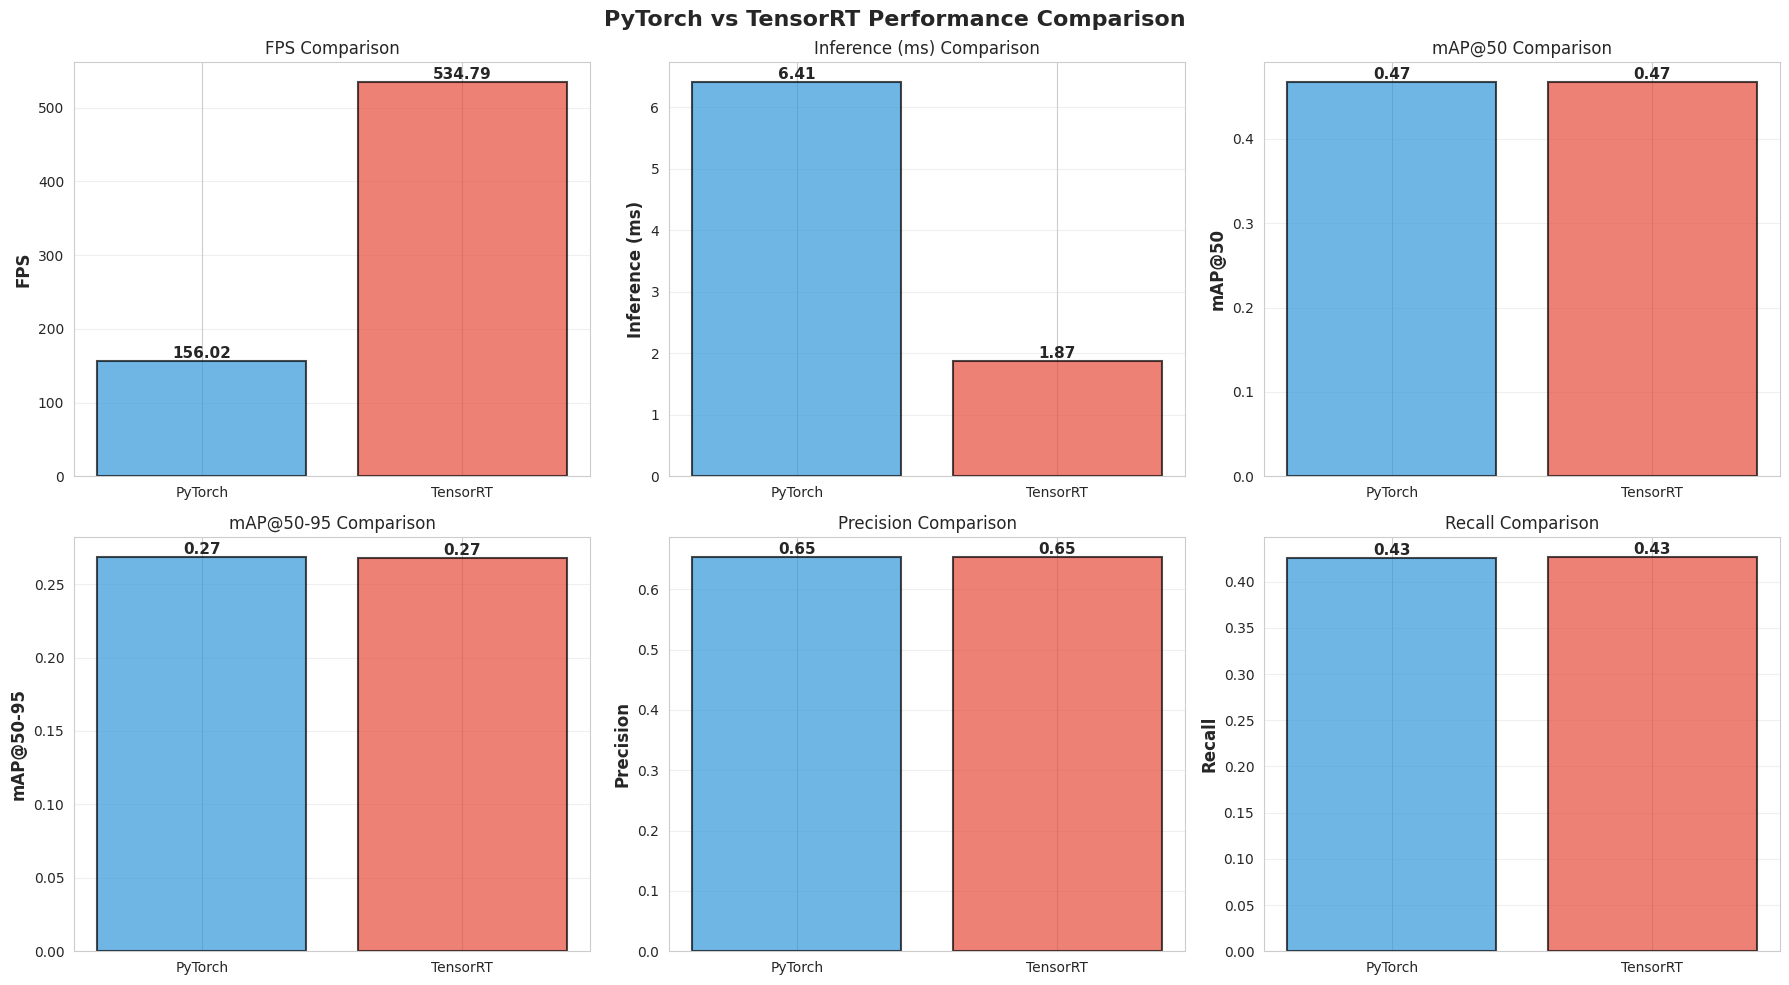

In [ ]:
# Performance Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PyTorch vs TensorRT Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['FPS', 'Inference (ms)', 'mAP@50', 'mAP@50-95', 'Precision', 'Recall']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = [pt_stats[metric], trt_stats[metric]]
    bars = ax.bar(['PyTorch', 'TensorRT'], values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Processing Pipeline Breakdown

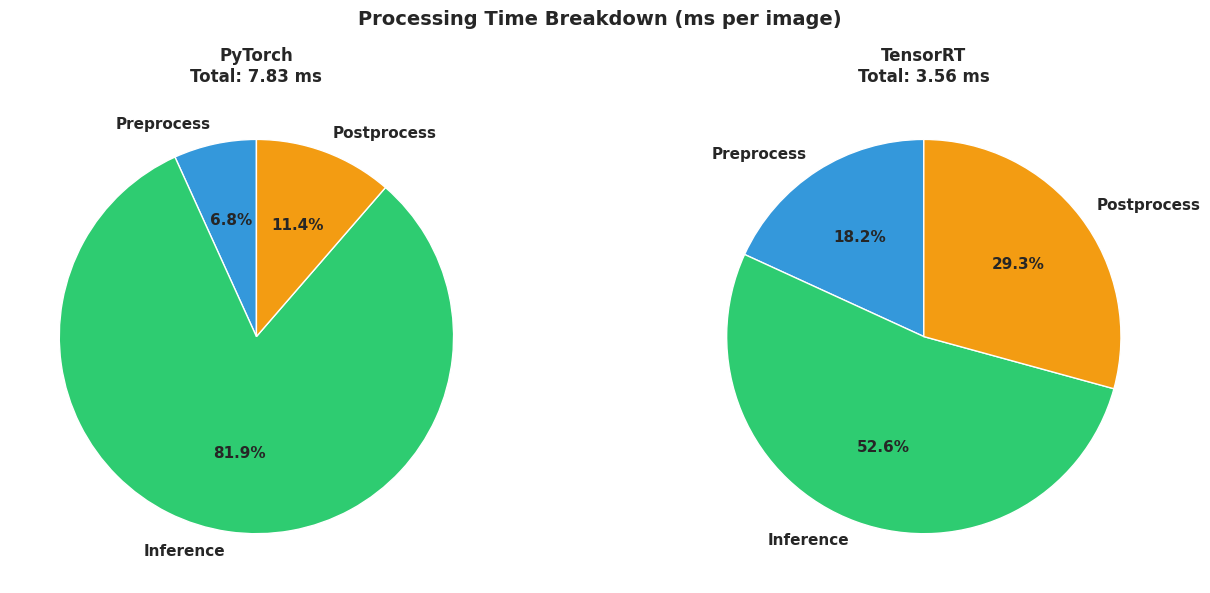

In [16]:
# Processing Time Breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Processing Time Breakdown (ms per image)', fontsize=14, fontweight='bold')

stages = ['Preprocess', 'Inference', 'Postprocess']
pt_times = [pt_stats['Preprocess (ms)'], pt_stats['Inference (ms)'], pt_stats['Postprocess (ms)']]
trt_times = [trt_stats['Preprocess (ms)'], trt_stats['Inference (ms)'], trt_stats['Postprocess (ms)']]

# PyTorch breakdown
ax1.pie(pt_times, labels=stages, autopct='%1.1f%%', startangle=90, 
        colors=['#3498db', '#2ecc71', '#f39c12'], textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title(f'PyTorch\nTotal: {pt_stats["Total (ms)"]:.2f} ms', fontsize=12, fontweight='bold')

# TensorRT breakdown
ax2.pie(trt_times, labels=stages, autopct='%1.1f%%', startangle=90,
        colors=['#3498db', '#2ecc71', '#f39c12'], textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title(f'TensorRT\nTotal: {trt_stats["Total (ms)"]:.2f} ms', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Per-Class Performance Analysis

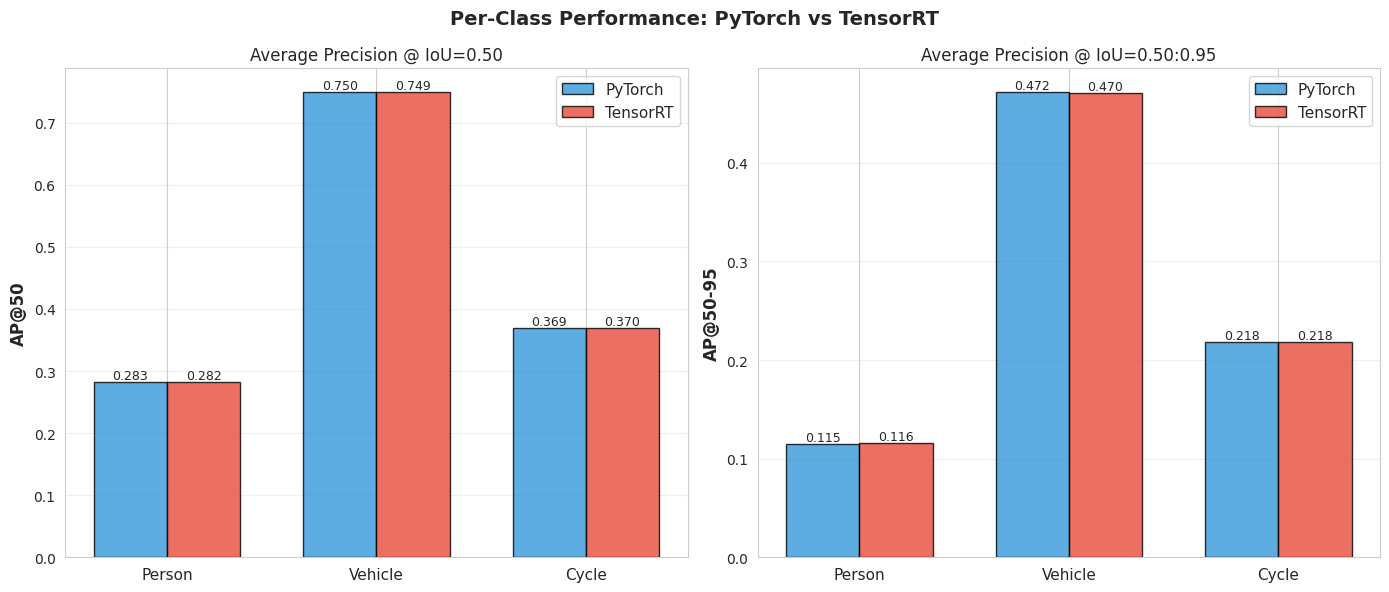

In [17]:
# Per-Class Performance
class_names = ['Person', 'Vehicle', 'Cycle']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Per-Class Performance: PyTorch vs TensorRT', fontsize=14, fontweight='bold')

# AP@50 comparison
x = np.arange(len(class_names))
width = 0.35

pt_ap50 = pt_stats['Per-Class AP50']
trt_ap50 = trt_stats['Per-Class AP50']

bars1 = ax1.bar(x - width/2, pt_ap50, width, label='PyTorch', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, trt_ap50, width, label='TensorRT', color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_ylabel('AP@50', fontsize=12, fontweight='bold')
ax1.set_title('Average Precision @ IoU=0.50', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(class_names, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# AP@50-95 comparison
pt_ap = pt_stats['Per-Class AP']
trt_ap = trt_stats['Per-Class AP']

bars3 = ax2.bar(x - width/2, pt_ap, width, label='PyTorch', color='#3498db', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, trt_ap, width, label='TensorRT', color='#e74c3c', alpha=0.8, edgecolor='black')

ax2.set_ylabel('AP@50-95', fontsize=12, fontweight='bold')
ax2.set_title('Average Precision @ IoU=0.50:0.95', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(class_names, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Model Efficiency Analysis

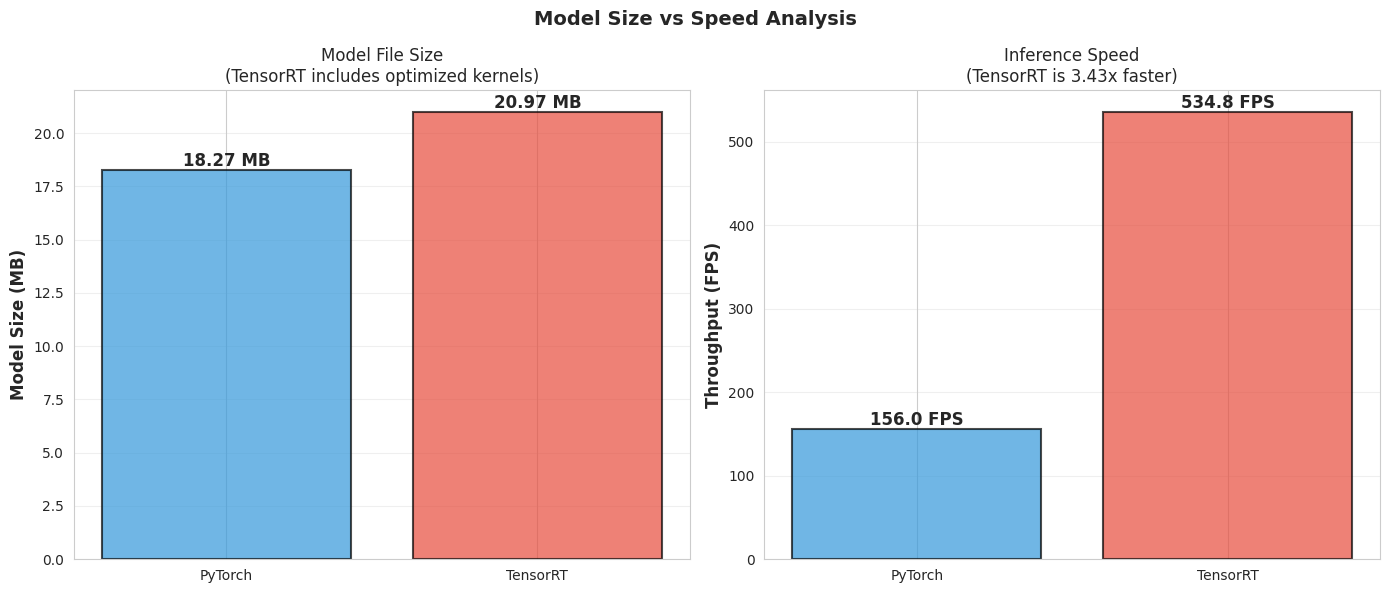

In [18]:
# Model Size and Speed Trade-off
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Size vs Speed Analysis', fontsize=14, fontweight='bold')

# Model size comparison
models = ['PyTorch', 'TensorRT']
sizes = [pt_stats['Model Size (MB)'], trt_stats['Model Size (MB)']]
colors_list = ['#3498db', '#e74c3c']
bars = ax1.bar(models, sizes, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:.2f} MB', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
ax1.set_title('Model File Size\n(TensorRT includes optimized kernels)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Throughput (images per second at batch=1)
throughput = [pt_stats['FPS'], trt_stats['FPS']]
bars = ax2.bar(models, throughput, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, fps in zip(bars, throughput):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{fps:.1f} FPS', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('Throughput (FPS)', fontsize=12, fontweight='bold')
ax2.set_title(f'Inference Speed\n(TensorRT is {speedup:.2f}x faster)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [20]:
# Summary table with percentage improvements
summary_data = {
    'Metric': ['FPS', 'Inference Latency (ms)', 'Model Size (MB)', 'mAP@50', 'mAP@50-95', 'Precision', 'Recall'],
    'PyTorch': [
        f"{pt_stats['FPS']:.2f}",
        f"{pt_stats['Inference (ms)']:.2f}",
        f"{pt_stats['Model Size (MB)']:.2f}",
        f"{pt_stats['mAP@50']:.4f}",
        f"{pt_stats['mAP@50-95']:.4f}",
        f"{pt_stats['Precision']:.4f}",
        f"{pt_stats['Recall']:.4f}"
    ],
    'TensorRT': [
        f"{trt_stats['FPS']:.2f}",
        f"{trt_stats['Inference (ms)']:.2f}",
        f"{trt_stats['Model Size (MB)']:.2f}",
        f"{trt_stats['mAP@50']:.4f}",
        f"{trt_stats['mAP@50-95']:.4f}",
        f"{trt_stats['Precision']:.4f}",
        f"{trt_stats['Recall']:.4f}"
    ],
    'Change': [
        f"+{((trt_stats['FPS'] / pt_stats['FPS'] - 1) * 100):.1f}%",
        f"{((trt_stats['Inference (ms)'] / pt_stats['Inference (ms)'] - 1) * 100):.1f}%",
        f"{'+' if trt_stats['Model Size (MB)'] > pt_stats['Model Size (MB)'] else ''}{((trt_stats['Model Size (MB)'] / pt_stats['Model Size (MB)'] - 1) * 100):.1f}%",
        f"{((trt_stats['mAP@50'] - pt_stats['mAP@50']) * 100):.2f}%",
        f"{((trt_stats['mAP@50-95'] - pt_stats['mAP@50-95']) * 100):.2f}%",
        f"{((trt_stats['Precision'] - pt_stats['Precision']) * 100):.2f}%",
        f"{((trt_stats['Recall'] - pt_stats['Recall']) * 100):.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*80)
display(summary_df.style.set_properties(**{'text-align': 'center'}))


PERFORMANCE COMPARISON SUMMARY


,Metric,PyTorch,TensorRT,Change
0,FPS,156.02,534.79,+242.8%
1,Inference Latency (ms),6.41,1.87,-70.8%
2,Model Size (MB),18.27,20.97,+14.8%
3,mAP@50,0.4674,0.4670,-0.04%
4,mAP@50-95,0.2684,0.2680,-0.04%
5,Precision,0.6535,0.6529,-0.06%
6,Recall,0.4254,0.4265,0.12%


## Conclusions

### Key Findings:

1. **Speed Performance**: TensorRT provides {speedup:.2f}x speedup through FP16 optimization, kernel fusion, and hardware-specific optimizations
2. **Accuracy Preservation**: Minimal accuracy difference shows TensorRT maintains model quality despite FP16 precision
3. **Model Size Trade-off**: TensorRT engine is larger (+14.6%) because it includes:
   - Pre-compiled optimized kernels for RTX 4050
   - Fused operations and optimized computation graph
   - FP16 precision constants and specialized data structures
4. **Real-time Capability**: Speed improvement enables real-time drone surveillance applications